In [1]:
from collections import namedtuple
from pathlib import Path
import json
import os
import shutil

import numpy as np
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
label_data = json.load(open("./EndoVis18/labels.json", "r"))
label_data

[{'name': 'background-tissue', 'color': [0, 0, 0], 'classid': 0},
 {'name': 'instrument-shaft', 'color': [0, 255, 0], 'classid': 1},
 {'name': 'instrument-clasper', 'color': [0, 255, 255], 'classid': 2},
 {'name': 'instrument-wrist', 'color': [125, 255, 12], 'classid': 3},
 {'name': 'kidney-parenchyma', 'color': [255, 55, 0], 'classid': 4},
 {'name': 'covered-kidney', 'color': [24, 55, 125], 'classid': 5},
 {'name': 'thread', 'color': [187, 155, 25], 'classid': 6},
 {'name': 'clamps', 'color': [0, 255, 125], 'classid': 7},
 {'name': 'suturing-needle', 'color': [255, 255, 125], 'classid': 8},
 {'name': 'suction-instrument', 'color': [123, 15, 175], 'classid': 9},
 {'name': 'small-intestine', 'color': [124, 155, 5], 'classid': 10},
 {'name': 'ultrasound-probe', 'color': [12, 255, 141], 'classid': 11}]

In [3]:
new_labels = {
 'instrument-shaft': {'color': [0, 255, 0], 'classid': 1},
 'instrument-clasper': {'color': [0, 255, 255], 'classid': 2},
 'instrument-wrist': {'color': [125, 255, 12], 'classid': 3}
}

# Visualization

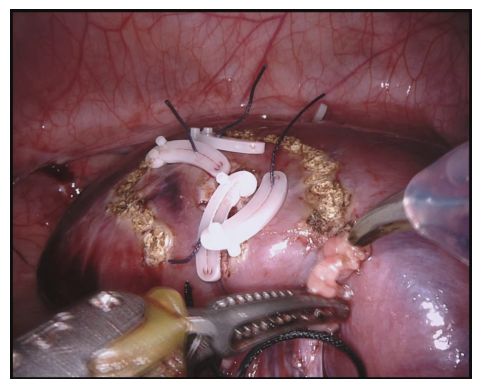

In [4]:
seq_num = "seq_01"
frame_num = "frame100.png"
image = io.imread(f"./EndoVis18/{seq_num}/left_frames/{frame_num}")
plt.imshow(image)
plt.axis('off')
plt.show()

### Training Labels

[  0  12  25  55 125 155 187 255]
(1024, 1280, 4)


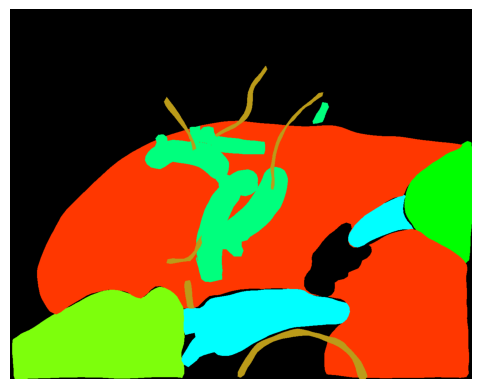

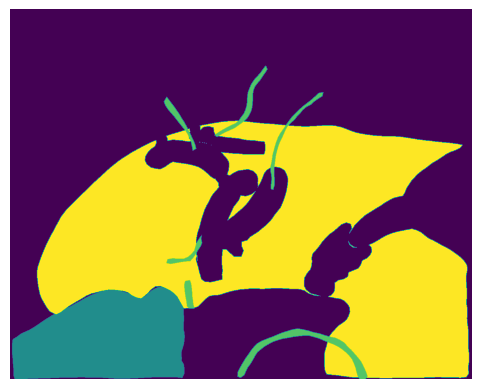

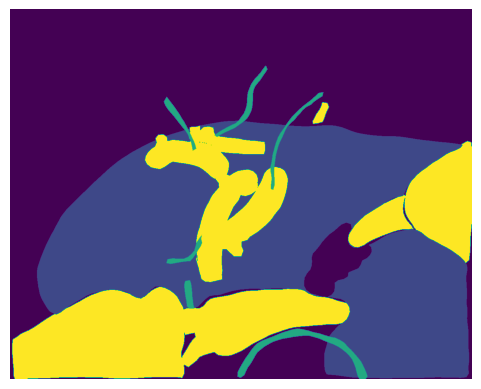

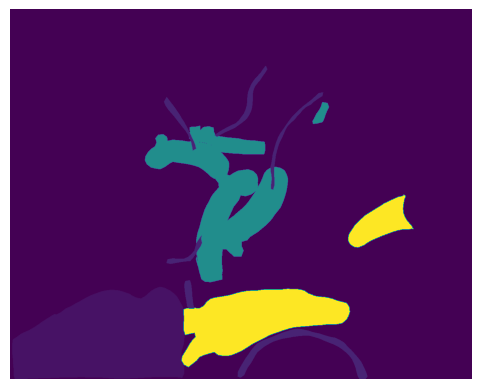

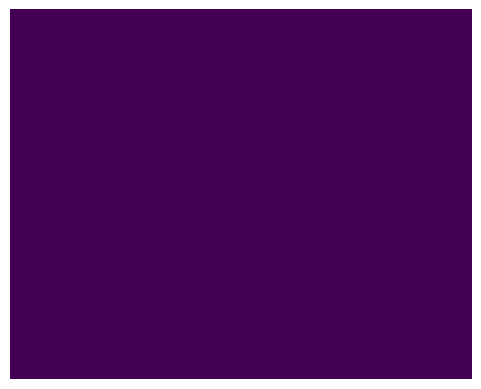

In [5]:
mask = io.imread(f"./EndoVis18/{seq_num}/labels/{frame_num}")
print(np.unique(mask))
print(mask.shape)
plt.imshow(mask);plt.axis('off');plt.show()
plt.imshow(mask[...,0]);plt.axis('off');plt.show()
plt.imshow(mask[...,1]);plt.axis('off');plt.show()
plt.imshow(mask[...,2]);plt.axis('off');plt.show()
plt.imshow(mask[...,3]);plt.axis('off');plt.show()

### Consider only `new_labels`

[0 1 2 3]


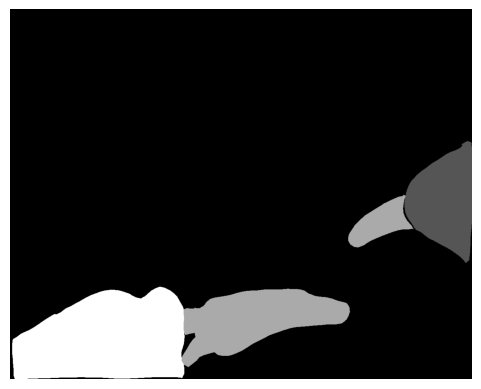

In [6]:
mask = io.imread(f"./EndoVis18/{seq_num}/labels/{frame_num}")[..., :-1]
new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
for key, val in new_labels.items():
    new_mask[np.all(mask == val["color"], axis=-1)] = val['classid']
print(np.unique(new_mask))
plt.imshow(new_mask, cmap="gray");plt.axis('off');plt.show()

In [7]:
main_folder = Path("./EndoVis18")

# Creating Masks

Perform the following:
* Crop the Image to remove black borders.
* Each Class for Type Segmentation is a folder, in which each mask is a Part Segmentation of Background, Shaft, Wrist, Jaw and Other with the mapping {
	"Background": 0,
	"Shaft": 10,
	"Wrist": 20,
	"Claspers": 30,
	"Probe": 40
}
* Combine All the Parts for each Instrument and map it to `INS_TYPE` code for Type Segmentaion
* Combine All the Instruments into a Single Mask, with pixel value corresponding to Instrument `class_id` 
* Also Combine all the Instruments into a Single Mask for Part Segmentation.
* And Combine All Parts and Type into a Single Mask for Type and Part Combined Segmentation.

### For Train Folder

Folder Structure

```markdown
> seq_01
    - camera_calibration.txt
    > labels
    > left_frames
    > right_frames
> seq_02
    - camera_calibration.txt
    > labels
    > left_frames
    > right_frames
...
> seq_07
> seq_09
> seq_10
...
> seq_20
```

In [8]:
save_folder = Path("./data")

In [23]:
for folder in sorted(main_folder.iterdir()):
    if folder.is_dir():
        # shutil.copytree(folder/"left_frames", save_folder/"frames"/folder.name, dirs_exist_ok=True)
        mask_save_path = save_folder/"masks"/"part_masks"/folder.name
        mask_save_path.mkdir(parents=True, exist_ok=True)
        for frame in tqdm(folder.glob("labels/*.png")):
            mask = io.imread(frame)[..., :-1]
            new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
            for key, val in new_labels.items():
                new_mask[np.all(mask == val["color"], axis=-1)] = val['classid']
            io.imsave(mask_save_path/frame.name, new_mask, check_contrast=False)

149it [00:24,  6.12it/s]
149it [00:23,  6.34it/s]
149it [00:26,  5.64it/s]
149it [00:24,  6.02it/s]
149it [00:23,  6.31it/s]
149it [00:21,  6.81it/s]
149it [00:23,  6.34it/s]
149it [00:25,  5.94it/s]
149it [00:24,  6.16it/s]
149it [00:22,  6.75it/s]
149it [00:27,  5.46it/s]
149it [00:22,  6.70it/s]
149it [00:22,  6.70it/s]
149it [00:21,  6.97it/s]
149it [00:34,  4.26it/s]
250it [00:38,  6.50it/s]
249it [00:36,  6.90it/s]
249it [00:36,  6.84it/s]
249it [00:36,  6.89it/s]


[0 1 2 3]


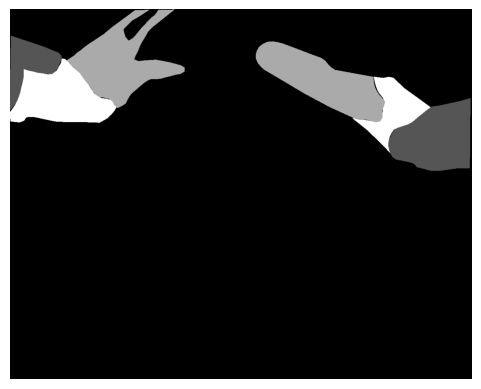

In [22]:
sample_mask = io.imread(save_folder/"masks"/"part_masks"/"seq_20"/"frame120.png")
print(np.unique(sample_mask))
plt.imshow(sample_mask, cmap="gray");plt.axis('off');plt.show()

### Binary Masks

In [25]:
for folder in sorted(main_folder.iterdir()):
    if folder.is_dir():
        mask_save_path = save_folder/"masks"/"binary_masks"/folder.name
        mask_save_path.mkdir(parents=True, exist_ok=True)
        for frame in tqdm(folder.glob("labels/*.png")):
            mask = io.imread(frame)[..., :-1]
            new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
            for key, val in new_labels.items():
                new_mask[np.all(mask == val["color"], axis=-1)] = 1
            io.imsave(mask_save_path/frame.name, new_mask, check_contrast=False)

149it [00:19,  7.53it/s]
149it [00:23,  6.33it/s]
149it [00:23,  6.42it/s]
149it [00:22,  6.75it/s]
149it [00:22,  6.75it/s]
149it [00:24,  6.16it/s]
149it [00:23,  6.38it/s]
149it [00:23,  6.33it/s]
149it [00:21,  7.03it/s]
149it [00:23,  6.31it/s]
149it [00:23,  6.47it/s]
149it [00:21,  6.87it/s]
149it [00:21,  6.88it/s]
149it [00:22,  6.54it/s]
149it [00:22,  6.63it/s]
250it [00:37,  6.63it/s]
249it [00:36,  6.87it/s]
249it [00:37,  6.57it/s]
249it [00:34,  7.19it/s]


[0 1]


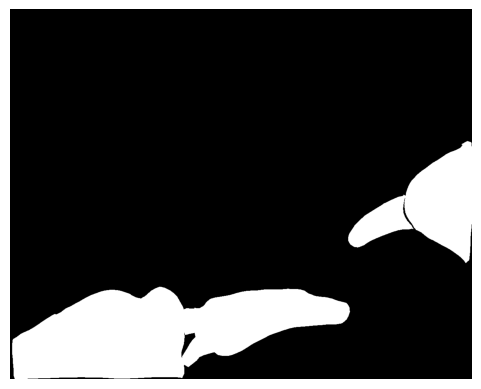

In [14]:
sample_mask = io.imread(save_folder/"masks"/"binary_masks"/"seq_01"/"frame100.png")
print(np.unique(sample_mask))
plt.imshow(sample_mask, cmap="gray");plt.axis('off');plt.show()

## For All Labels (not just Instruments)

### Multi Class

In [9]:
for folder in sorted(main_folder.iterdir()):
    if folder.is_dir():
        mask_save_path = save_folder/"masks"/"all_masks"/folder.name
        mask_save_path.mkdir(parents=True, exist_ok=True)
        for frame in tqdm(folder.glob("labels/*.png")):
            mask = io.imread(frame)[..., :-1]
            new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
            for label_dict in label_data:
                new_mask[np.all(mask == label_dict["color"], axis=-1)] = label_dict['classid']
            io.imsave(mask_save_path/frame.name, new_mask, check_contrast=False)

149it [01:24,  1.75it/s]
149it [01:26,  1.73it/s]
149it [01:28,  1.68it/s]
149it [01:17,  1.91it/s]
149it [01:22,  1.81it/s]
149it [01:17,  1.93it/s]
149it [01:17,  1.91it/s]
149it [01:15,  1.97it/s]
149it [01:16,  1.96it/s]
149it [01:22,  1.80it/s]
149it [01:21,  1.82it/s]
149it [16:30,  6.65s/it]
149it [01:18,  1.90it/s]
149it [01:19,  1.88it/s]
149it [01:17,  1.91it/s]
250it [02:13,  1.87it/s]
249it [02:19,  1.79it/s]
249it [02:18,  1.80it/s]
249it [02:07,  1.96it/s]


[0 1 2 3 4 6 7]


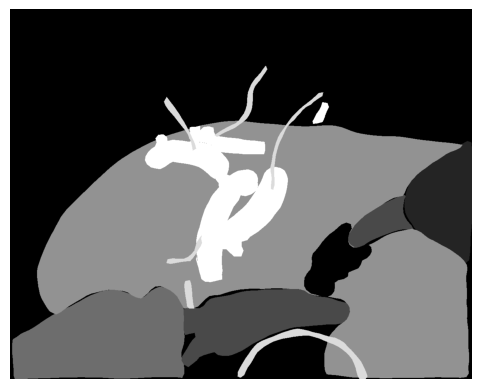

In [11]:
sample_mask = io.imread(save_folder/"masks"/"all_masks"/"seq_01"/"frame100.png")
print(np.unique(sample_mask))
plt.imshow(sample_mask, cmap="gray");plt.axis('off');plt.show()

### All Classes Binary

In [13]:
for folder in sorted(main_folder.iterdir()):
    if folder.is_dir():
        mask_save_path = save_folder/"masks"/"all_binary_masks"/folder.name
        mask_save_path.mkdir(parents=True, exist_ok=True)
        for frame in tqdm(folder.glob("labels/*.png")):
            mask = io.imread(frame)[..., :-1]
            new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
            for label_dict in label_data:
                if label_dict["classid"] == 0: # background
                   continue 
                new_mask[np.all(mask == label_dict["color"], axis=-1)] = 1
            io.imsave(mask_save_path/frame.name, new_mask, check_contrast=False)

149it [01:17,  1.92it/s]
149it [01:10,  2.12it/s]
149it [01:07,  2.20it/s]
149it [01:06,  2.25it/s]
149it [01:06,  2.24it/s]
149it [01:05,  2.26it/s]
149it [01:05,  2.26it/s]
149it [01:05,  2.27it/s]
149it [01:05,  2.27it/s]
149it [01:06,  2.24it/s]
149it [01:05,  2.29it/s]
149it [01:04,  2.30it/s]
149it [01:04,  2.31it/s]
149it [01:09,  2.15it/s]
149it [01:06,  2.25it/s]
250it [01:55,  2.16it/s]
249it [01:58,  2.09it/s]
249it [01:50,  2.26it/s]
249it [01:52,  2.21it/s]


[0 1]


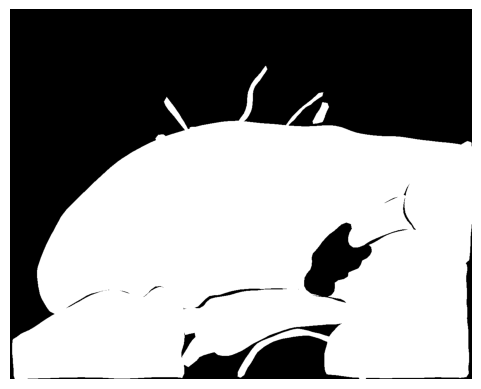

In [14]:
sample_mask = io.imread(save_folder/"masks"/"all_binary_masks"/"seq_01"/"frame100.png")
print(np.unique(sample_mask))
plt.imshow(sample_mask, cmap="gray");plt.axis('off');plt.show()